In [1]:
%config Completer.use_jedi = False

In [2]:
from astropy.wcs import WCS
import healpy as hp
from pyuvdata import UVData, UVBeam
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import glob as glob

In [3]:
import casatasks
from casatasks import importuvfits, exportfits, tclean,importfits

In [4]:
import matplotlib.image as mpimg

In [5]:
import polcal

In [6]:
from scipy.interpolate import interp1d

In [7]:
import time

In [8]:
import imager

In [9]:
import glob, copy

In [10]:
import uvtools

### Retain data

In [11]:
good_ants = list(set([9,10,20,22,31,43,53,64,65,72,80,81,88,89,96,97,104,105,112]) - set([22,43,80,81]))

In [12]:
uvd_raw = UVData()
uvd_raw.read("/lustre/aoc/projects/hera/jtan/HERA19/lst.2457548.18h18m00s.18h29m50s.uvcRP.phased.uvfits", antenna_nums=good_ants)

In [13]:
uvd_raw_conj = UVData()
uvd_raw_conj.read("/lustre/aoc/projects/hera/jtan/HERA19/lst.2457548.18h18m00s.18h29m50s.uvcRP.phased.conj.uvfits", antenna_nums=good_ants)

In [14]:
np.all(uvd_raw_conj.data_array[:,:,:,0] == np.conj(uvd_raw.data_array[:,:,:,0])), \
np.all(uvd_raw_conj.data_array[:,:,:,1] == np.conj(uvd_raw.data_array[:,:,:,1])),\
np.all(uvd_raw_conj.data_array[:,:,:,2] == np.conj(uvd_raw.data_array[:,:,:,3])),\
np.all(uvd_raw_conj.data_array[:,:,:,3] == np.conj(uvd_raw.data_array[:,:,:,2]))

(True, True, True, True)

In [15]:
uvd_sim = UVData()
uvd_sim.read('/lustre/aoc/projects/hera/jtan/uvsim/gsm_nside128/lst.2457548.18h18m00s.18h29m50s.HERAband.uvfits', antenna_nums=good_ants)

In [16]:
uvd_sim_r = UVData()
uvd_sim_r.read('/lustre/aoc/projects/hera/jtan/uvsim/gsm_nside128/lst.2457548.18h18m00s.18h29m50s.HERAband.reverted.dipole.uvfits', antenna_nums=good_ants)

### Calibration

rum four times:
<br>
uvd_raw on uvd_sim, uvd_raw on uvd_sim_r, uvd_raw_conj on uvd_sim, uvd_raw_conj on uvd_sim_r

In [13]:
freqs = np.arange(1,1024,10)

In [42]:
Niterations = 300
for (uvd_model,text_model) in zip([uvd_sim, uvd_sim_r],["original_dipole","reverted_dipole"]):
    for (uvd_data,text_data) in zip([uvd_raw, uvd_raw_conj],["original_data","conjugated_data"]):
        uv_polcal = polcal.uvdata_pol_calibrator(model_data=uvd_model, real_data=uvd_data, mode="model_based")
        residuals_freq = np.zeros((len(freqs), Niterations, 2 ,2))
        gain_array_iter_freq = np.zeros((len(freqs), Niterations, uvd_model.Nants_data, 2 ,2)).astype(np.complex128)
        for j, freq in enumerate(freqs):
            uv_polcal.data_slice(use_all_times=True, base_freq_range=[freq], prod_freq_range=[freq], use_all_ants=True)
            start_time = time.time()
            gain_array_iter, residuals = uv_polcal.Wirtinger_lm_cal(damping_para=2., update_damping_para_per_loop=True, including_autobaseline=False, Niteration=Niterations, verbose=True)
            residuals_freq[j,:,:,:] = residuals
            gain_array_iter_freq[j,:,:,:,:] = gain_array_iter
        np.save("2457548_calibration_residuals_{}_on_{}".format(text_data, text_model), residuals_freq)
        np.save("2457548_iterated_gains_{}_on_{}".format(text_data,text_model), gain_array_iter_freq)

#### compare residuals 

In [18]:
residual_raw_on_sim, residual_raw_on_sim_r, residual_raw_conj_on_sim, residual_raw_conj_on_sim_r = np.load("2457548_calibration_residuals_original_data_on_original_dipole.npy"), \
np.load("2457548_calibration_residuals_original_data_on_reverted_dipole.npy"), np.load("2457548_calibration_residuals_conjugated_data_on_original_dipole.npy"),  \
np.load("2457548_calibration_residuals_conjugated_data_on_reverted_dipole.npy")

choose a freqency channel

Text(0.5, 1.0, 'conjugated_data_on_reverted_dipole')

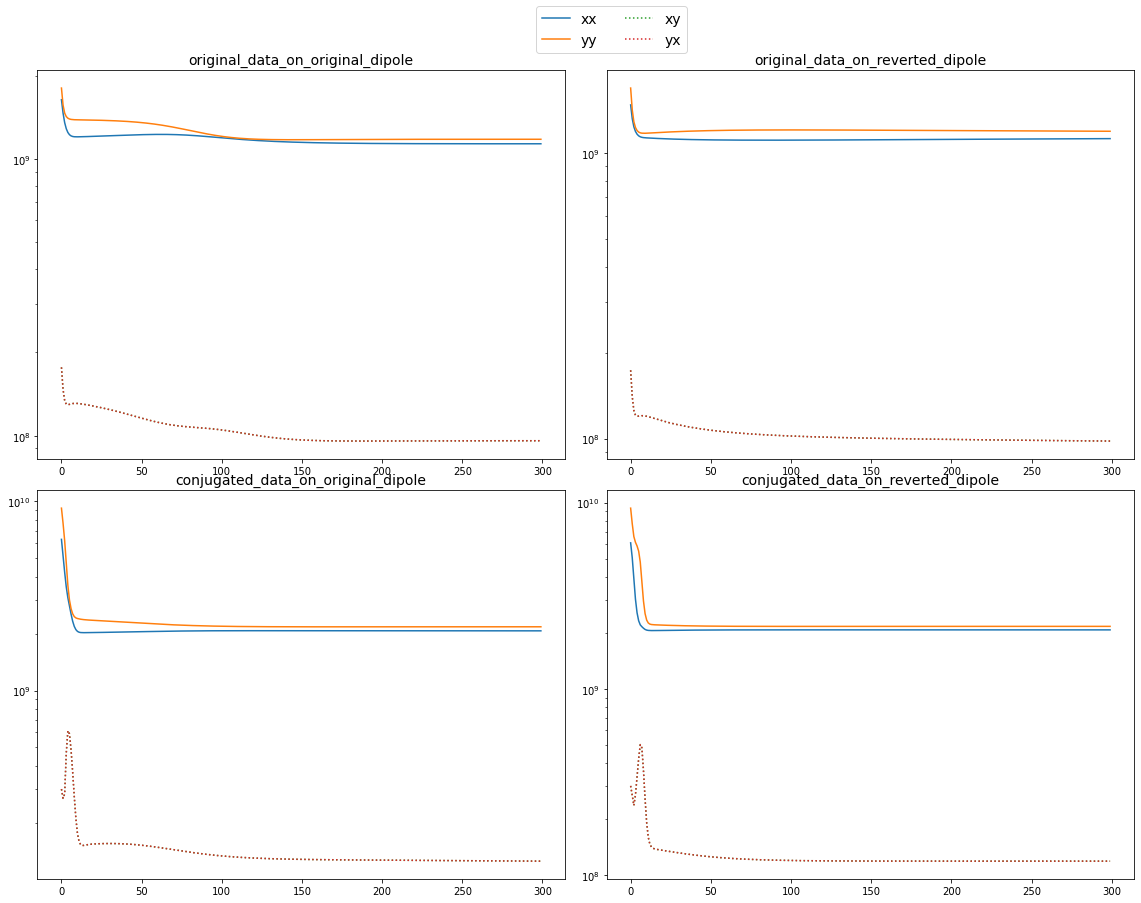

In [28]:
fig, axes = plt.subplots(figsize=(16,12), ncols=2, nrows=2)
ax = axes[0,0]
ax.plot(residual_raw_on_sim[62,:,0,0], label="xx")
ax.plot(residual_raw_on_sim[62,:,1,1], label="yy")
ax.plot(residual_raw_on_sim[62,:,0,1], ls=":", label="xy")
ax.plot(residual_raw_on_sim[62,:,1,0], ls=":", label="yx")
ax.set_yscale('log')
ax.set_title("original_data_on_original_dipole", fontsize=14)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.53,1.05), loc='upper center', fontsize=14, ncol=2,)
fig.tight_layout()

ax = axes[0,1]
ax.plot(residual_raw_on_sim_r[62,:,0,0], label="xx")
ax.plot(residual_raw_on_sim_r[62,:,1,1], label="yy")
ax.plot(residual_raw_on_sim_r[62,:,0,1], ls=":", label="xy")
ax.plot(residual_raw_on_sim_r[62,:,1,0], ls=":", label="yx")
ax.set_yscale('log')
ax.set_title("original_data_on_reverted_dipole", fontsize=14)

ax = axes[1,0]
ax.plot(residual_raw_conj_on_sim[62,:,0,0], label="xx")
ax.plot(residual_raw_conj_on_sim[62,:,1,1], label="yy")
ax.plot(residual_raw_conj_on_sim[62,:,0,1], ls=":", label="xy")
ax.plot(residual_raw_conj_on_sim[62,:,1,0], ls=":", label="yx")
ax.set_yscale('log')
ax.set_title("conjugated_data_on_original_dipole", fontsize=14)

ax = axes[1,1]
ax.plot(residual_raw_conj_on_sim_r[62,:,0,0], label="xx")
ax.plot(residual_raw_conj_on_sim_r[62,:,1,1], label="yy")
ax.plot(residual_raw_conj_on_sim_r[62,:,0,1], ls=":", label="xy")
ax.plot(residual_raw_conj_on_sim_r[62,:,1,0], ls=":", label="yx")
ax.set_yscale('log')
ax.set_title("conjugated_data_on_reverted_dipole", fontsize=14)

In [ ]:
"""
for i, JD in enumerate(JDs):
    _iterated_gains = np.load("{}_iterated_gains_reverted_dipole.npy".format(JD))
    for freq_index in range(_iterated_gains.shape[0]):
        for ant_index in range(_iterated_gains.shape[2]):
            fig, ax = plt.subplots(figsize=(8,6))
            ax.plot(abs(_iterated_gains[freq_index,:,ant_index,0,0]), c='red', label="Gx")
            ax.plot(abs(_iterated_gains[freq_index,:,ant_index,1,1]), c='green', label='Gy')
            ax.plot(abs(_iterated_gains[freq_index,:,ant_index,0,1]), ls=':', c='purple', label="Dxy")
            ax.plot(abs(_iterated_gains[freq_index,:,ant_index,1,0]), ls=":", c='blue', label="Dyx")
            ax.set_xlabel("Iterations", fontsize=16)
            ax.set_ylabel("Amplitudes", fontsize=16)
            ax.set_yscale('log')
            ax.tick_params(axis='both', which='both', labelsize=16, direction='out')
            ax.legend(loc='lower right', fontsize=16)
            ax.set_title("ant:{}_freq:{}_flag:{}".format(
                ant_index, freqs[freq_index], np.all(uvd_raw_list[i].flag_array[:,0,freqs[freq_index], 0])), 
                fontsize=16)
            fig.savefig("/lustre/aoc/projects/hera/jtan/Yack/iterated_gains/{}/ant{}_freq{}_reverted_dipole.png".format(JD, ant_index, freqs[freq_index]))
            plt.close()
"""

#### compare final gains 

In [17]:
gains_raw_on_sim, gains_raw_on_sim_r, gains_raw_conj_on_sim, gains_raw_conj_on_sim_r = np.load("2457548_iterated_gains_original_data_on_original_dipole.npy"), \
np.load("2457548_iterated_gains_original_data_on_reverted_dipole.npy"), np.load("2457548_iterated_gains_conjugated_data_on_original_dipole.npy"),  \
np.load("2457548_iterated_gains_conjugated_data_on_reverted_dipole.npy")

pick a frequency channel and antenna

Text(0.5, 1.0, 'conjugated_data_on_reverted_dipole')

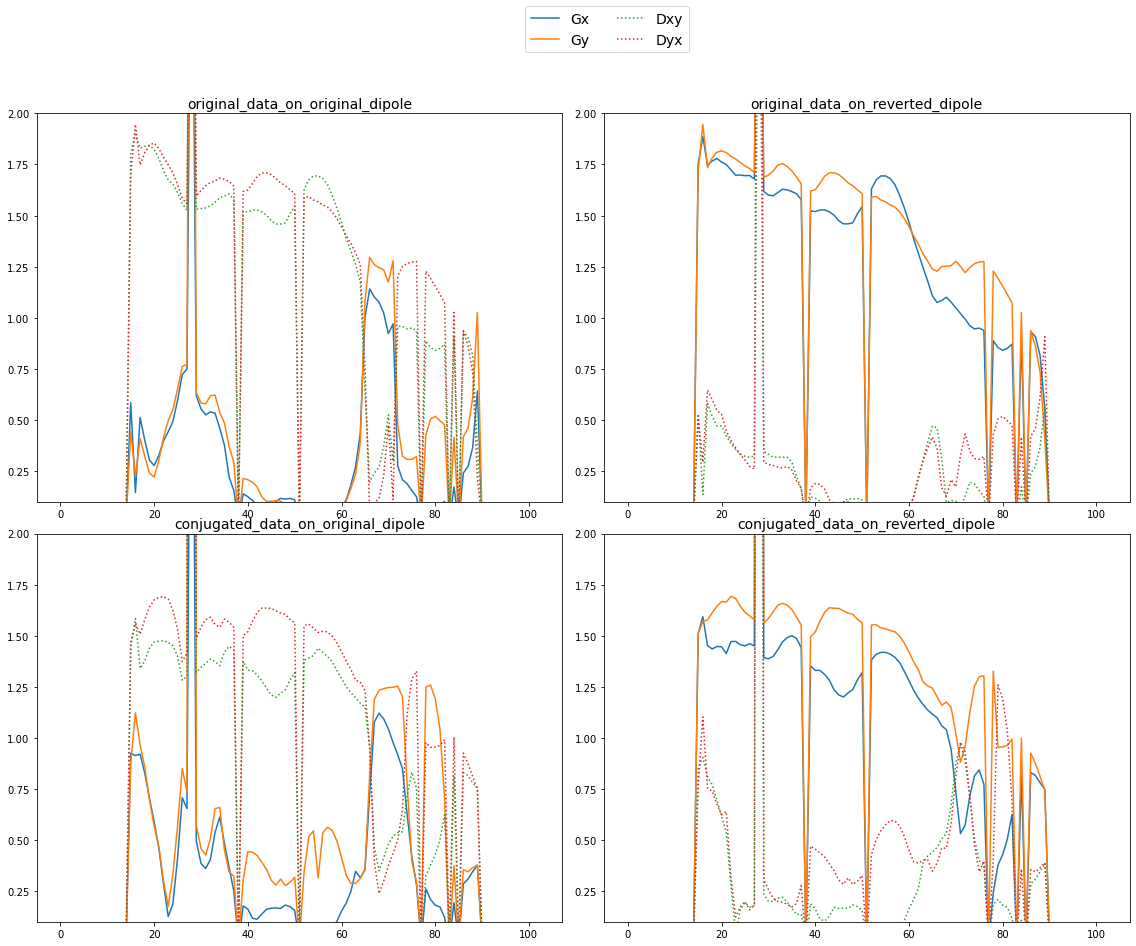

In [43]:
fig, axes = plt.subplots(figsize=(16,12), ncols=2, nrows=2)
ant = 2
ax = axes[0,0]
ax.plot(np.abs(gains_raw_on_sim[:,-1,ant,0,0]), label="Gx")
ax.plot(np.abs(gains_raw_on_sim[:,-1,ant,1,1]), label="Gy")
ax.plot(np.abs(gains_raw_on_sim[:,-1,ant,0,1]), ls=":", label="Dxy")
ax.plot(np.abs(gains_raw_on_sim[:,-1,ant,1,0]), ls=":", label="Dyx")
ax.set_ylim(1e-1,2)
ax.set_title("original_data_on_original_dipole", fontsize=14)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.53,1.10), loc='upper center', fontsize=14, ncol=2,)
fig.tight_layout()

ax = axes[0,1]
ax.plot(np.abs(gains_raw_on_sim_r[:,-1,ant,0,0]))
ax.plot(np.abs(gains_raw_on_sim_r[:,-1,ant,1,1]))
ax.plot(np.abs(gains_raw_on_sim_r[:,-1,ant,0,1]), ls=":")
ax.plot(np.abs(gains_raw_on_sim_r[:,-1,ant,1,0]), ls=":")
ax.set_ylim(1e-1,2)
ax.set_title("original_data_on_reverted_dipole", fontsize=14)

ax = axes[1,0]
ax.plot(np.abs(gains_raw_conj_on_sim[:,-1,ant,0,0]))
ax.plot(np.abs(gains_raw_conj_on_sim[:,-1,ant,1,1]))
ax.plot(np.abs(gains_raw_conj_on_sim[:,-1,ant,0,1]), ls=":")
ax.plot(np.abs(gains_raw_conj_on_sim[:,-1,ant,1,0]), ls=":")
ax.set_ylim(1e-1,2)
ax.set_title("conjugated_data_on_original_dipole", fontsize=14)

ax = axes[1,1]
ax.plot(np.abs(gains_raw_conj_on_sim_r[:,-1,ant,0,0]))
ax.plot(np.abs(gains_raw_conj_on_sim_r[:,-1,ant,1,1]))
ax.plot(np.abs(gains_raw_conj_on_sim_r[:,-1,ant,0,1]), ls=":")
ax.plot(np.abs(gains_raw_conj_on_sim_r[:,-1,ant,1,0]), ls=":")
ax.set_ylim(1e-1,2)
ax.set_title("conjugated_data_on_reverted_dipole", fontsize=14)

Interestingly, we see whether or not we conjugate the raw data, the calibration on the simulated data with non-reverted dipoles fail in having large off-diagonal Jones matrix

Then we will try applying gains from calibrations based on reverted-dipole simulations back to both original and conjugated data

### Apply gains

#### on reverted dipole sim

In [56]:
new_gains_original_on_reverted,  new_gains_conjugated_on_reverted = np.zeros((1024, 15, 2, 2)).astype(np.complex128), np.zeros((1024, 15, 2, 2)).astype(np.complex128)

In [57]:
new_gains_original_on_reverted[freqs,:,:,:] = gains_raw_on_sim_r[:,-1,:,:,:]

In [58]:
new_gains_conjugated_on_reverted[freqs,:,:,:] = gains_raw_conj_on_sim_r[:,-1,:,:,:]

In [59]:
new_gains_original_on_reverted = np.transpose(new_gains_original_on_reverted, (1,0,2,3))

In [60]:
new_gains_conjugated_on_reverted = np.transpose(new_gains_conjugated_on_reverted, (1,0,2,3))

In [64]:
rm /lustre/aoc/projects/hera/jtan/HERA19calibrated/lst.2457548.18h18m00s.18h29m50s.uvcRP.phased.conj.calibration_on_reverted_dipole.uvfits

In [65]:
uvd_raw_cal = polcal.apply_gains(uvd_raw, new_gains_original_on_reverted, 
                             need_interpolate=True, interpolate_freq_index=freqs, 
                             need_inverse=True, epsilon=1e-12)
uvd_raw_cal.write_uvfits('/lustre/aoc/projects/hera/jtan/HERA19calibrated/lst.2457548.18h18m00s.18h29m50s.uvcRP.phased.calibration_on_reverted_dipole.uvfits')

In [66]:
uvd_raw_conj_cal = polcal.apply_gains(uvd_raw_conj, new_gains_conjugated_on_reverted, 
                             need_interpolate=True, interpolate_freq_index=freqs, 
                             need_inverse=True, epsilon=1e-12)
uvd_raw_conj_cal.write_uvfits('/lustre/aoc/projects/hera/jtan/HERA19calibrated/lst.2457548.18h18m00s.18h29m50s.uvcRP.phased.conj.calibration_on_reverted_dipole.uvfits')

In [18]:
uvd_raw_cal_reverted_dipole, uvd_raw_conj_cal_reverted_dipole = UVData(), UVData()

In [19]:
uvd_raw_cal_reverted_dipole.read('/lustre/aoc/projects/hera/jtan/HERA19calibrated/lst.2457548.18h18m00s.18h29m50s.uvcRP.phased.calibration_on_reverted_dipole.uvfits', antenna_nums=good_ants)

In [21]:
uvd_raw_conj_cal_reverted_dipole.read('/lustre/aoc/projects/hera/jtan/HERA19calibrated/lst.2457548.18h18m00s.18h29m50s.uvcRP.phased.conj.calibration_on_reverted_dipole.uvfits', antenna_nums=good_ants)

## difference in uv plane as 1d function

We would like compare the uv-plane of uvd_raw_cal_reverted_dipole, uvd_raw_conj_cal_reverted_dipole with uvd_sim_r

In [53]:
from cycler import cycler
def diff_uv_1d(uvd1, uvd2, check_metadata=True, bins=50, title=None):
    """
    Parameters
    ----------
    uvd1, uvd2 : pyuvdata.UVData
        Input UVData objects which contain the visibilities to be differenced
        and any relevant metadata.
    check_metadata : bool, optional
        Whether to check that the metadata for `uvd1` and `uvd2` match.
        See ``utils.check_uvd_pair_metadata`` docstring for details on
        how the metadata are compared. If `check_metadata` is set to
        False, but the metadata don't agree, then the plotter may or
        may not error out, depending on how the metadata disagree.
        Default behavior is to check the metadata.
    bins : int, optional
        Number of bins to use for regridding the u and v arrays.
    """
    # check the metadata unless instructed otherwise
    if check_metadata:
        uvtools.utils.check_uvd_pair_metadata(uvd1, uvd2)

    # convert polarization to index

    # load in relevant metadata
    bl_vecs = uvd1.uvw_array
    freqs = uvd1.freq_array[0]

    # import astropy constants to convert freq to wavelength
    from astropy.constants import c
    wavelengths = c.value / freqs

    # get uvw vectors; shape = (Nfreq, Nblts, 3)
    uvw_vecs = np.array([bl_vecs / wavelength for wavelength in wavelengths])

    # reshape uvw vectors to (Nblts, Nfreq, 3)
    uvw_vecs = np.swapaxes(uvw_vecs, 0, 1)

    # get the u and v arrays, flattened
    uvals, vvals = uvw_vecs[:,:,0].flatten(), uvw_vecs[:,:,1].flatten()
    uv_radius = np.sqrt(uvals**2+vvals**2)
    
    # get the visbilities
    vis1, vis2 = np.zeros((4, *uvals.shape)).astype(np.complex128), np.zeros((4, *uvals.shape)).astype(np.complex128) 
    vis1[0,:], vis1[1,:], vis1[2,:], vis1[3,:] = uvd1.data_array[:,0,:,0].flatten(), uvd1.data_array[:,0,:,1].flatten(), uvd1.data_array[:,0,:,2].flatten(), uvd1.data_array[:,0,:,3].flatten()
    vis2[0,:], vis2[1,:], vis2[2,:], vis2[3,:] = uvd2.data_array[:,0,:,0].flatten(), uvd2.data_array[:,0,:,1].flatten(), uvd2.data_array[:,0,:,2].flatten(), uvd2.data_array[:,0,:,3].flatten()
    
    abs_vis1, abs_vis2 = np.abs(vis1), np.abs(vis2)
    phase_vis1, phase_vis2 = np.angle(vis1), np.angle(vis2)
    # get the regridded radius
    uv_radius_bins = np.linspace(uv_radius.min(), uv_radius.max(), bins+1)
    
    accumulate_bins_vis1, accumulate_bins_vis2 = np.zeros((2,4, bins+1)), np.zeros((2,4,bins+1)) 
    for (i,bin_radius) in enumerate(uv_radius_bins):
        for pol in range(4):
            accumulate_bins_vis1[0,pol,i] += np.sum(abs_vis1[pol,:] [uv_radius<=bin_radius])
            accumulate_bins_vis1[1,pol,i] += np.sum(phase_vis1[pol,:] [uv_radius<=bin_radius])
            accumulate_bins_vis2[0,pol,i] += np.sum(abs_vis2[pol,:] [uv_radius<=bin_radius])
            accumulate_bins_vis2[1,pol,i] += np.sum(phase_vis2[pol,:] [uv_radius<=bin_radius])
        
    # setup the figure
    fig, axes = plt.subplots(figsize=(14,6), ncols=2)
    
    ax = axes[0]
    ax.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']))
    l1 = ax.plot(uv_radius_bins,  accumulate_bins_vis1[0,:,:].T, )
    l2 = ax.plot(uv_radius_bins,  accumulate_bins_vis2[0,:,:].T, ls=":", alpha=0.5)
    ax.set_ylim(np.min([np.min(accumulate_bins_vis1[0,:,:]), np.min(accumulate_bins_vis2[0,:,:])]), np.max([np.max(accumulate_bins_vis1[0,:,:]), np.max(accumulate_bins_vis2[0,:,:])]))
    ax.set_title("Magnitudes", fontsize=16)
    ax.set_xlabel("uv radius", fontsize=16)
    ax.tick_params(axis='both', which='both', bottom=False, labelsize=12)
    fig.legend([*l1,*l2], ["uvd1_xx", "uvd1_yy", "uvd1_xy", "uvd1_yx", "uvd2_xx", "uvd2_yy", "uvd2_xy", "uvd2_yx"], bbox_to_anchor=(0.53,1.10), loc='upper center', fontsize=14, ncol=4,)
   
    ax = axes[1]
    ax.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']))
    l1 = ax.plot(uv_radius_bins,  accumulate_bins_vis1[1,:,:].T, )
    l2 = ax.plot(uv_radius_bins,  accumulate_bins_vis2[1,:,:].T, ls=":", )
    ax.set_ylim(np.min([np.min(accumulate_bins_vis1[1,:,:]), np.min(accumulate_bins_vis2[1,:,:])]), np.max([np.max(accumulate_bins_vis1[1,:,:]), np.max(accumulate_bins_vis2[1,:,:])]))
    ax.set_title("Phases", fontsize=16)
    ax.set_xlabel("uv radius", fontsize=16)
    ax.tick_params(axis='both', which='both', bottom=False, labelsize=12)
    
    if title is not None:
        fig.suptitle(str(title), y=1.15, fontsize=16)

### compare uvd_sim_r with uvd_raw_cal_reverted_dipole

In [55]:
uvd_sim_r_fake_uvw = copy.deepcopy(uvd_sim_r)
uvd_sim_r_fake_uvw.uvw_array = uvd_raw_cal_reverted_dipole.uvw_array

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does n

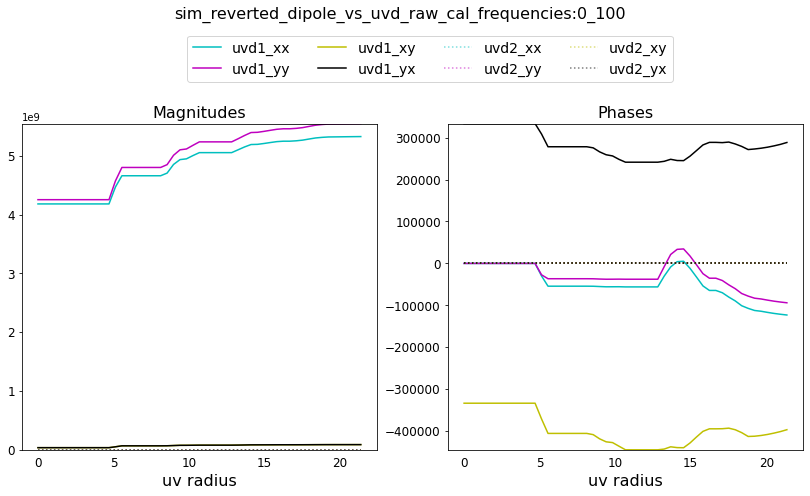

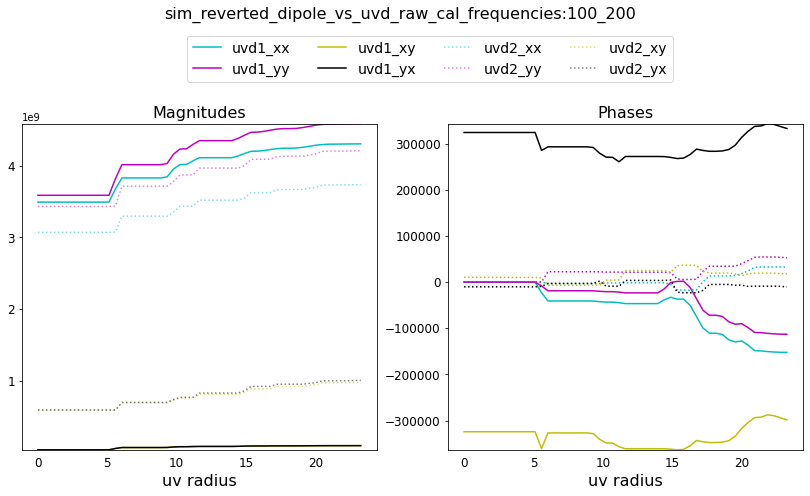

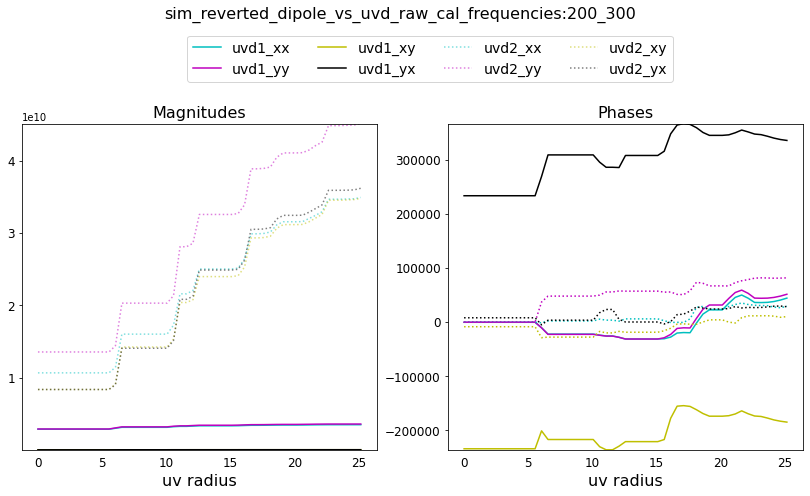

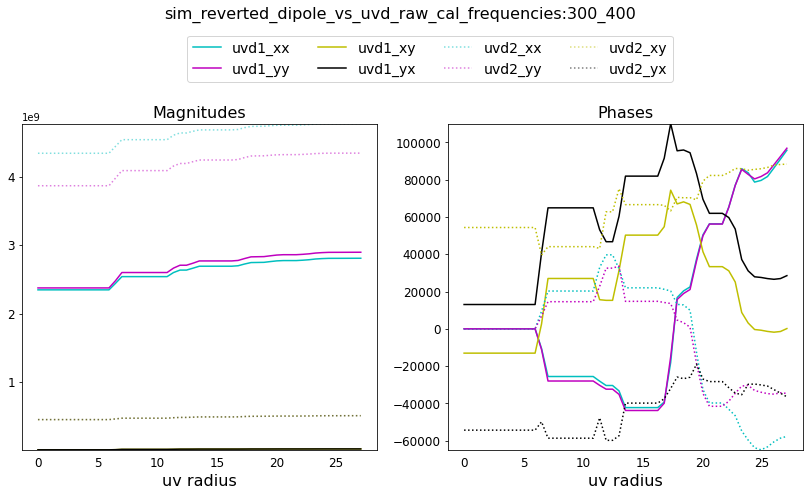

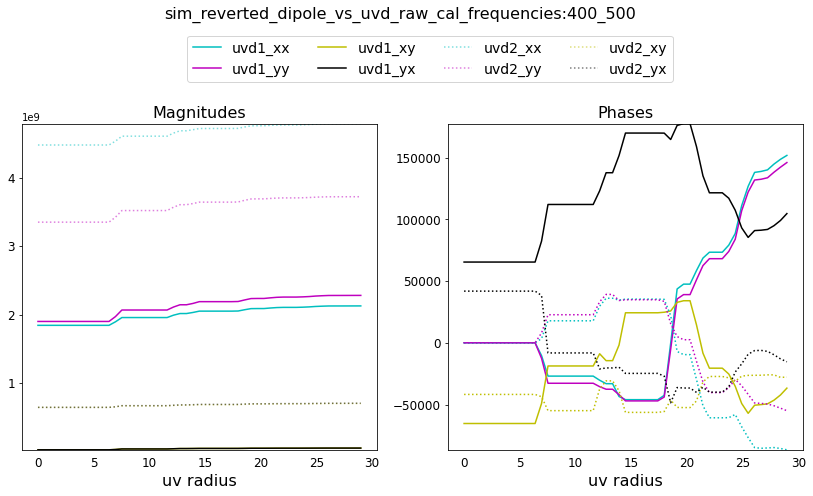

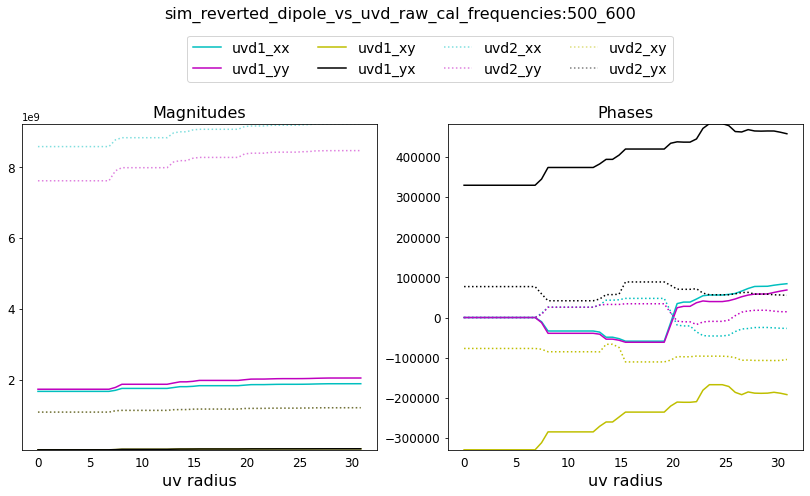

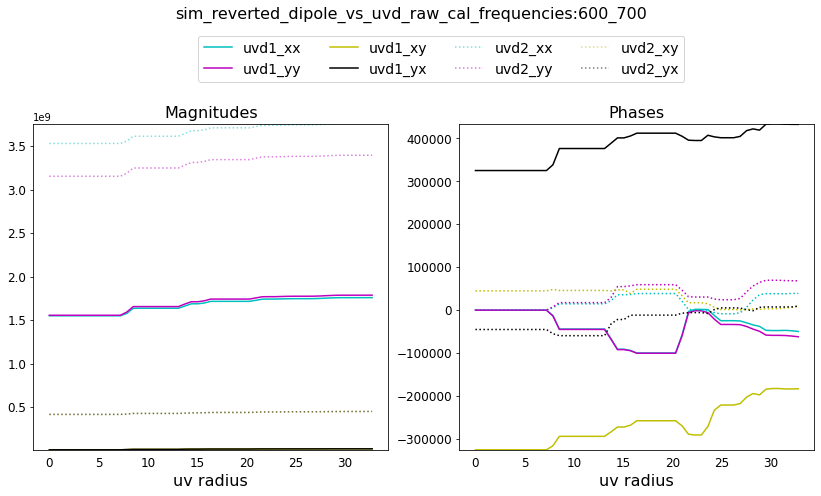

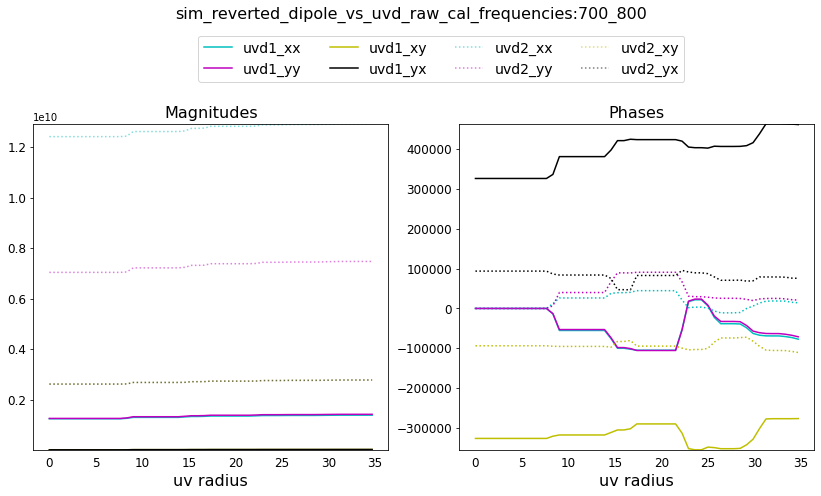

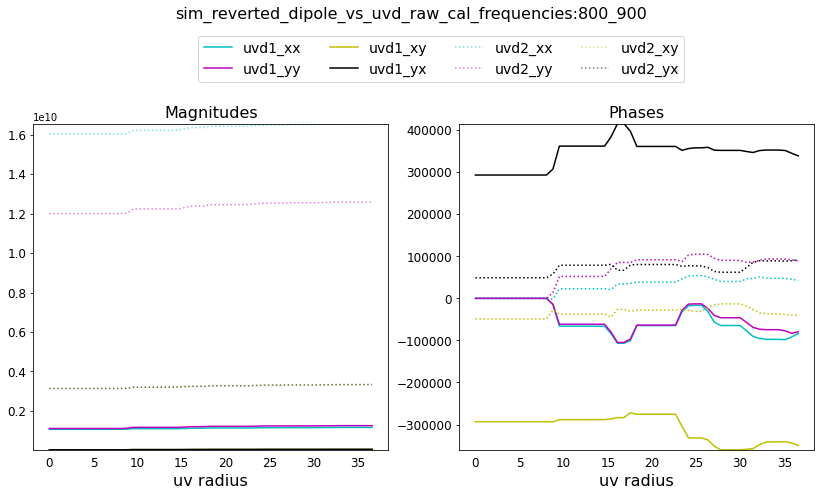

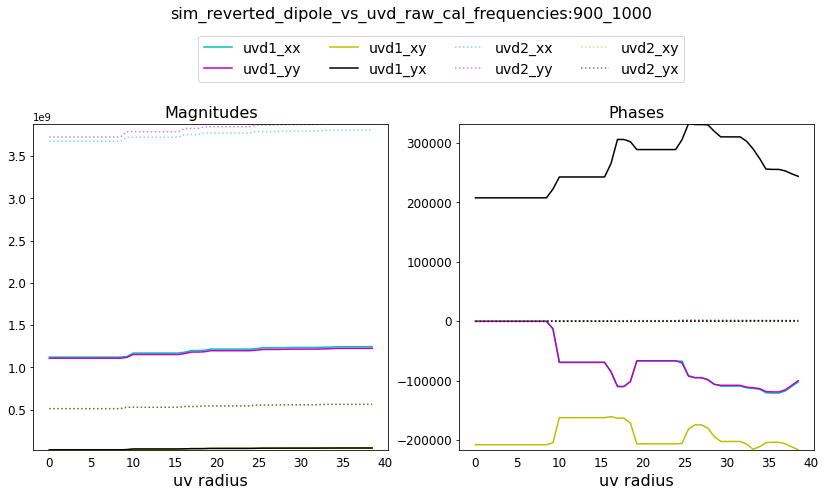

In [58]:
for spec_window in [(0,100),(100,200),(200,300),(300,400),(400,500),(500,600),(600,700),(700,800),(800,900),(900,1000)]:
    diff_uv_1d(uvd_sim_r_fake_uvw.select(freq_chans=list(range(*spec_window)), inplace=False),  uvd_raw_cal_reverted_dipole.select(freq_chans=list(range(*spec_window)), inplace=False), \
               title="sim_reverted_dipole_vs_uvd_raw_cal_frequencies:{}_{}".format(*spec_window))

### compare uvd_sim_r with uvd_raw_conj_cal_reverted_dipole

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 102.77629175112129 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does n

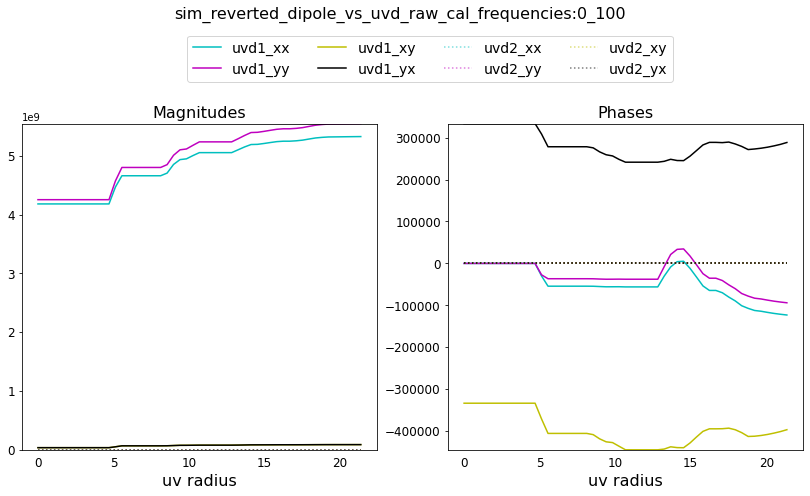

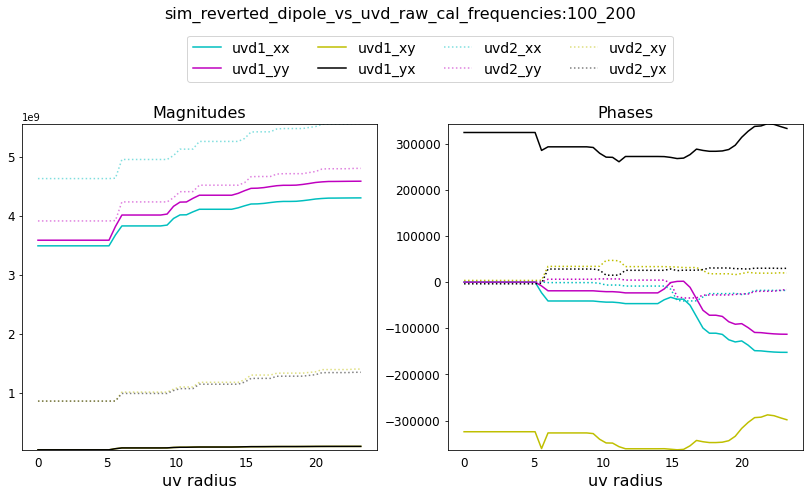

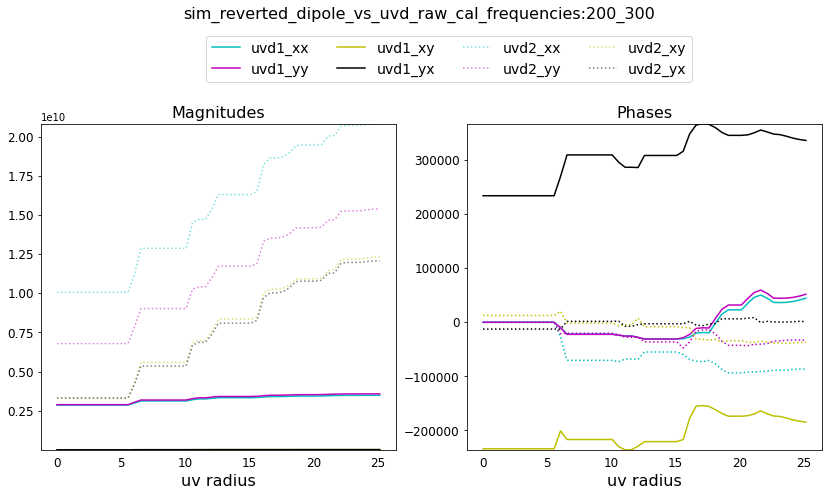

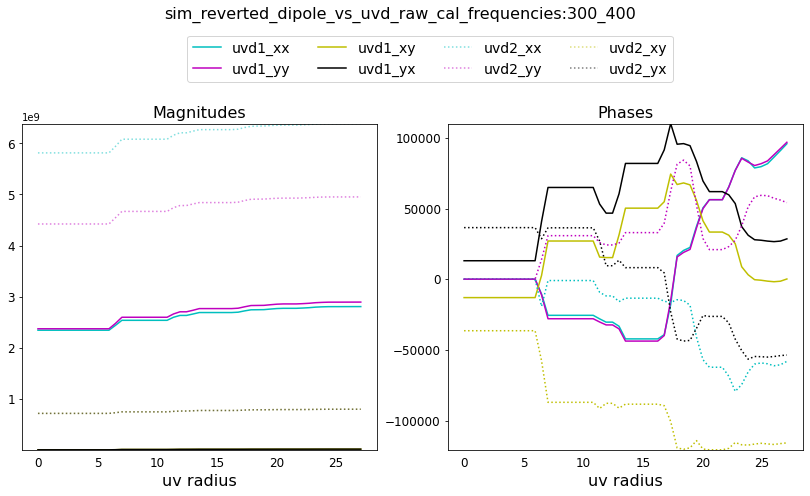

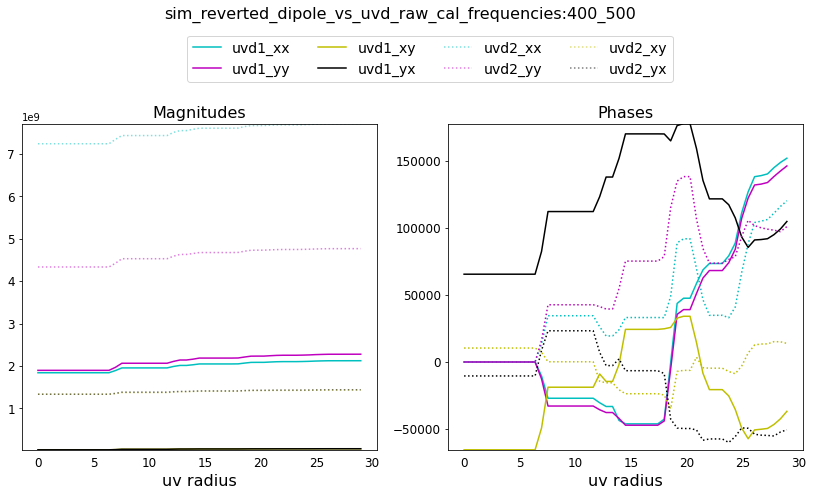

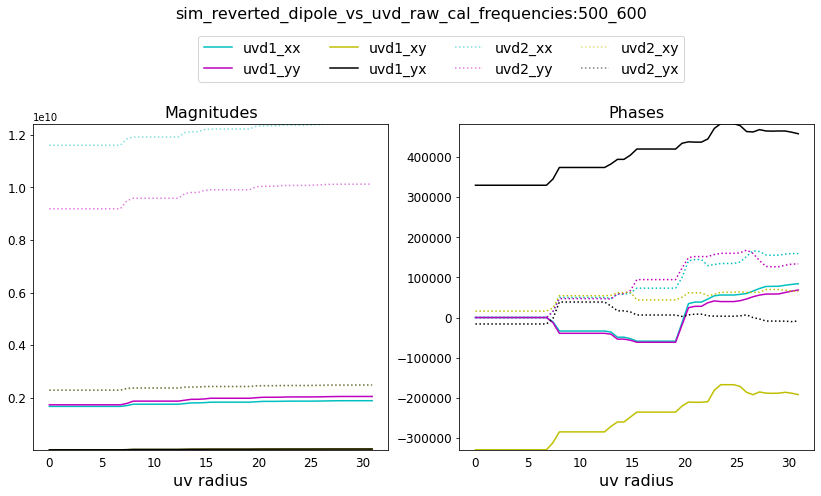

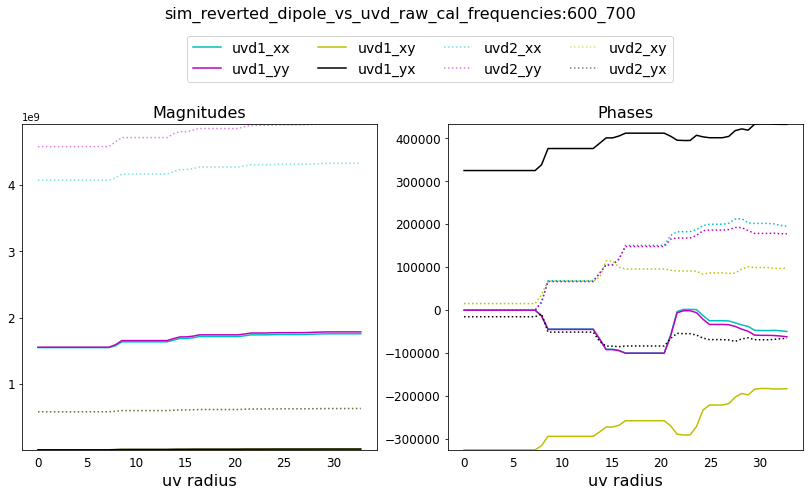

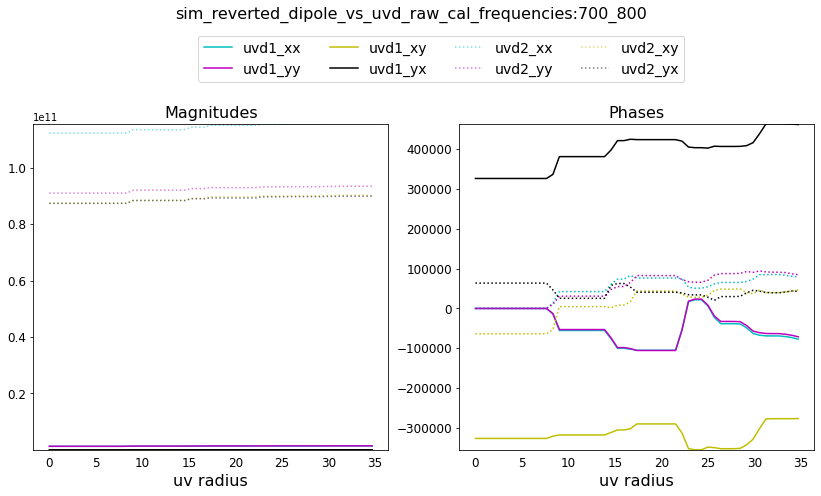

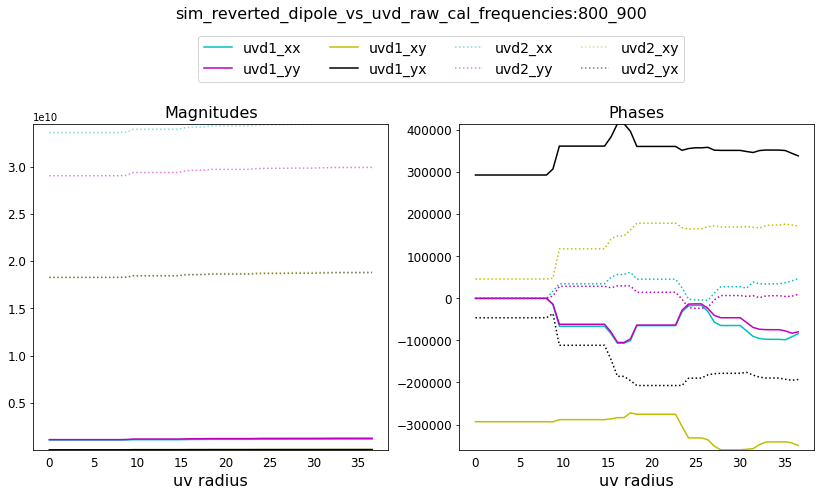

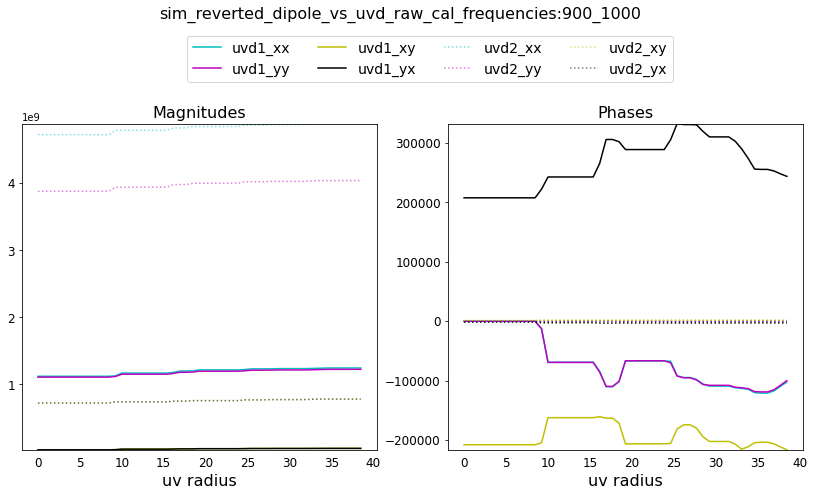

In [60]:
for spec_window in [(0,100),(100,200),(200,300),(300,400),(400,500),(500,600),(600,700),(700,800),(800,900),(900,1000)]:
    diff_uv_1d(uvd_sim_r_fake_uvw.select(freq_chans=list(range(*spec_window)), inplace=False),  uvd_raw_conj_cal_reverted_dipole.select(freq_chans=list(range(*spec_window)), inplace=False), \
               title="sim_reverted_dipole_vs_uvd_raw_cal_frequencies:{}_{}".format(*spec_window))